In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = np.array((500.12,500.9,499.85,500.44,501.6,501.78,499.75,499.44,499.47,500.56,498.49,498.39,498.56,498.85,498.87,500.57,501.24,500.91,498.96,
                 499.37,499.69,499.24,499.49,500.9,501.9,501.04,499.88,501.65,502.46,501.09))
df = pd.DataFrame(data, columns = ['Xbar'])
# Inspect the dataset
df.head()

,Xbar
0,500.12
1,500.90
2,499.85
3,500.44
4,501.60


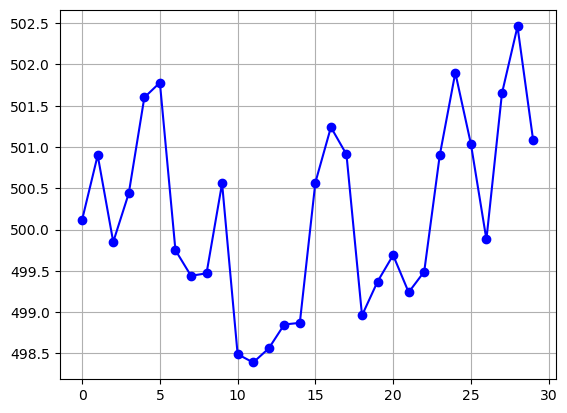

In [2]:
# Plot the data first
plt.plot(df, color='b', linestyle='-', marker='o')
plt.grid()
plt.show()

Runs test p-value = 0.142


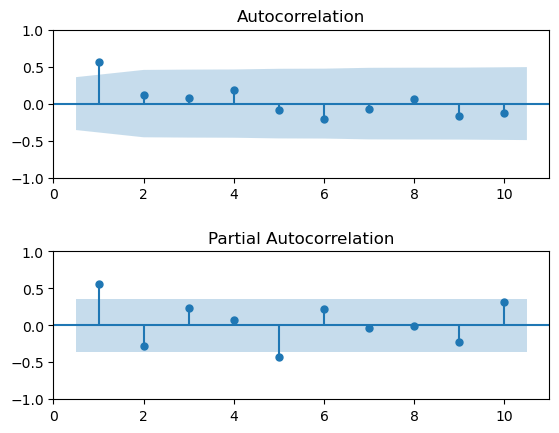

In [3]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df['Xbar'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()


In [4]:
df['lag1'] = df['Xbar'].shift(1)
X = df.iloc[1:, 1:]
y = df.iloc[1:, 0]

In [5]:
import qda
stepwise = qda.StepwiseRegression(add_constant = True, direction = 'both', alpha_to_enter = 0.15, alpha_to_remove = 0.15)

# Fit the model
model = stepwise.fit(y, X)

Stepwise Regression

######################################
### Step 1
-------------------
Forward Selection

COEFFICIENTS
------------
 Term       Coef  P-Value
const 214.531972 0.012716
 lag1   0.571132 0.001422

MODEL SUMMARY
-------------
       S     R-sq  R-sq(adj)
0.964537 0.318681   0.293447

######################################
### Step 2
-------------------
Forward Selection
All predictors have been included in the model. Exiting stepwise.
-------------------


In [6]:
results = model.model_fit
qda.summary(results)

REGRESSION EQUATION
-------------------
Xbar =  + 214.532 const + 0.571 lag1

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value  P-Value
const 214.5320  80.3811   2.6689   0.0127
 lag1   0.5711   0.1607   3.5537   0.0014

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.9645 0.3187     0.2934

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value  P-Value
Regression  1.0 11.7492 11.7492  12.6290   0.0014
     const  1.0  6.6270  6.6270   7.1232   0.0127
      lag1  1.0 11.7492 11.7492  12.6290   0.0014
     Error 27.0 25.1189  0.9303      NaN      NaN
     Total 28.0 36.8681     NaN      NaN      NaN


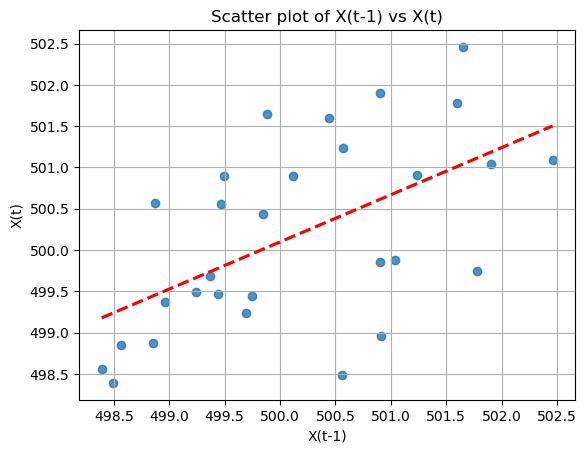

In [11]:
import seaborn as sns
#create scatterplot with regression line using seaborn and set axis labels
sns.regplot(x=df['lag1'], y=df['Xbar'], ci=None, line_kws={'color':'red', 'ls':'--'})
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.grid()


Shapiro-Wilk test p-value = 0.371


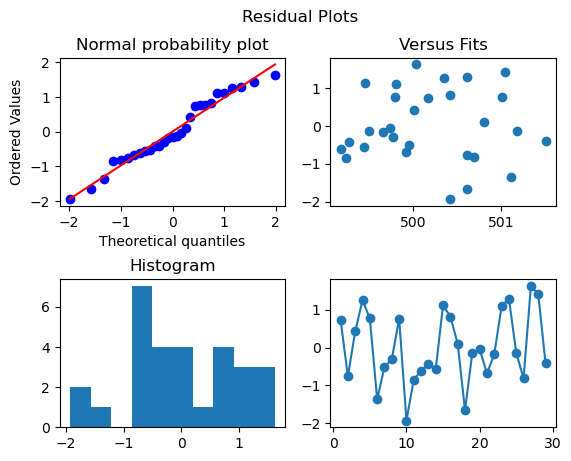

In [7]:
#Check on residuals
residuals = results.resid
fits = results.fittedvalues
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the residuals
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

Runs test p-value on the residuals = 0.231


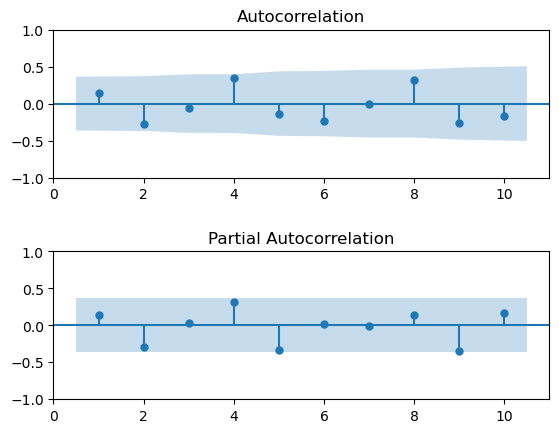

In [8]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

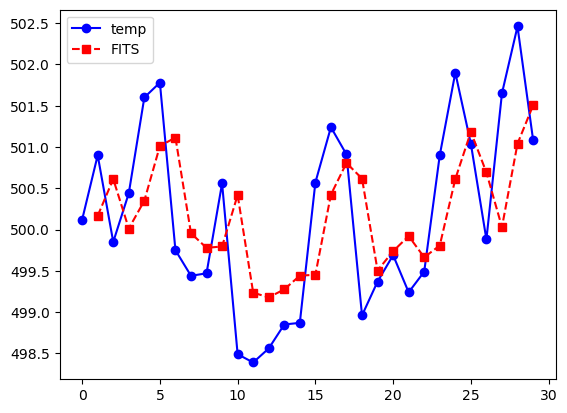

In [9]:
plt.plot(df['Xbar'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(results.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

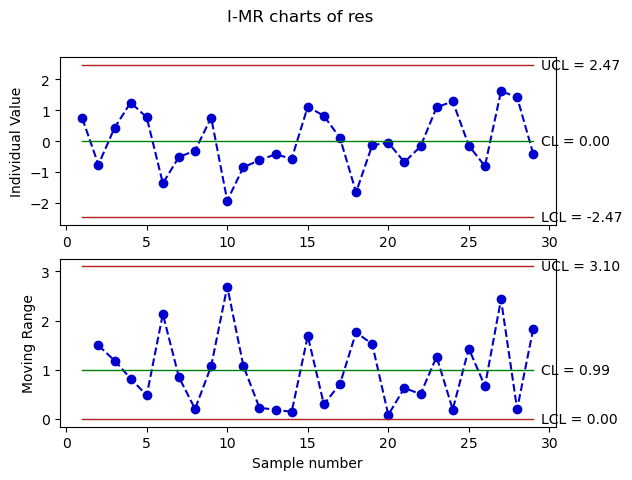

In [10]:
alpha=0.005
K_alpha=stats.norm.ppf(1-alpha/2)
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(results.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res',K=K_alpha)